<h1><center>Capstone Group 4 - Diabetes Readmission (Model Building)</center></h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import re
%matplotlib inline

### We started with our final processed data dummies.csv whose processing is in the project_section2

In [2]:
dfraw = pd.read_csv('dummies.csv')

### Due to computational limitation the entire dataset wasn't able to used thus 70% data was randomly selected 

In [3]:
df = dfraw.sample(frac=0.7,random_state=0)

In [4]:
X = df.drop('readmitted',axis=1)
y = df['readmitted']

In [5]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['readmitted'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['readmitted']==0]))
print("Number of subscription",len(os_data_y[os_data_y['readmitted']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['readmitted']==1])/len(os_data_X))

length of oversampled data is  62340
Number of no subscription in oversampled data 31170
Number of subscription 31170
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [6]:
X = os_data_X
y = os_data_y

In [7]:
from sklearn.preprocessing import StandardScaler, Normalizer
sc = StandardScaler()
norm = Normalizer()
X_std = sc.fit_transform(X)
X_norm = norm.fit_transform(X)

## Standardized Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=0)

### Decision Tree (Base)

In [9]:
from sklearn.tree import DecisionTreeClassifier
DT_S = DecisionTreeClassifier(criterion = "entropy", random_state=0)
DT_S.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [10]:
dtree_pred = DT_S.predict(X_test)
cm = confusion_matrix(y_test,dtree_pred)
print(cm)

[[8245 1009]
 [ 815 8633]]


In [11]:
cr = classification_report(y_test,dtree_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      9254
           1       0.90      0.91      0.90      9448

    accuracy                           0.90     18702
   macro avg       0.90      0.90      0.90     18702
weighted avg       0.90      0.90      0.90     18702



In [12]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.90
Precision is 0.90
Recall is 0.91


### Random Forest (Base)

In [13]:
from sklearn.ensemble import RandomForestClassifier
RF_S = RandomForestClassifier(criterion = "entropy")
RF_S.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
rm_prd = RF_S.predict(X_test)
cm = confusion_matrix(y_test,rm_prd)
print(cm)

[[9240   14]
 [ 916 8532]]


In [15]:
cr = classification_report(y_test,rm_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       1.00      0.90      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [16]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.95
Precision is 1.00
Recall is 0.90


### Decision Tree (CV)

In [17]:
from sklearn.model_selection import GridSearchCV

DT_S = DecisionTreeClassifier(criterion= "entropy",random_state=0)
dt_params = {'max_depth': np.arange(
    1, 25), 'min_samples_leaf': np.arange(2, 25)}

GS_dt = GridSearchCV(DT_S, dt_params, cv=5, scoring='roc_auc')
GS_dt.fit(X_std, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 

In [18]:
GS_dt.best_params_

{'max_depth': 21, 'min_samples_leaf': 24}

In [19]:
dtree = DecisionTreeClassifier(max_depth=21, criterion = "entropy", min_samples_split=24,random_state=0)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=21, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=24,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [20]:
dtree_pred = dtree.predict(X_test)
cm = confusion_matrix(y_test,dtree_pred)
print(cm)

[[8652  602]
 [ 955 8493]]


In [21]:
cr = classification_report(y_test,dtree_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      9254
           1       0.93      0.90      0.92      9448

    accuracy                           0.92     18702
   macro avg       0.92      0.92      0.92     18702
weighted avg       0.92      0.92      0.92     18702



In [22]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

Accuracy is 0.92
Precision is 0.93
Recall is 0.90


### Random Forest (CV)

In [23]:
import sklearn.model_selection as model_selection

auc_avg = []
auc_var = []
x_axis = np.arange(1, 40)
for ne in x_axis:
    RF_S = RandomForestClassifier(n_estimators=ne, random_state=0)
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    auc = model_selection.cross_val_score(
        RF_S, X_std, y, cv=5, scoring='roc_auc')
    auc_avg.append(1-np.mean(auc))
    auc_var.append(np.var(auc, ddof=1))

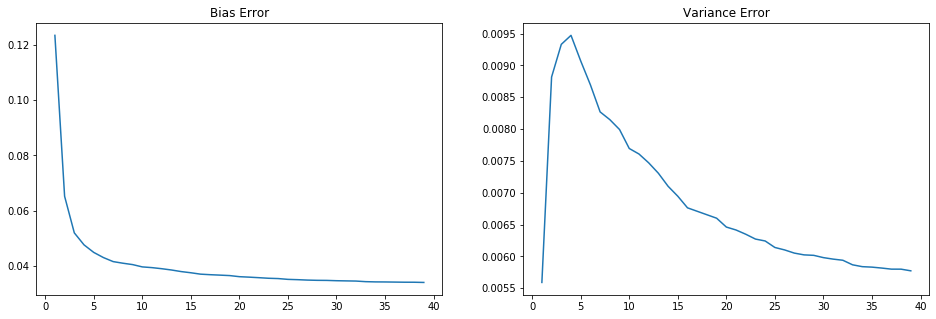

In [24]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Bias Error')
plt.plot(x_axis,auc_avg)

plt.subplot(1,2,2)
plt.title('Variance Error')
plt.plot(x_axis,auc_var)
plt.show()

In [25]:
#Finding Lowest Variance Error
print(np.argmin(auc_var))
print(auc_var[np.argmin(auc_var)])
print(auc_avg[np.argmin(auc_var)])

0
0.00558961387092567
0.1233718318896374


In [26]:
#Finding Lowest Bias Error
print(np.argmin(auc_avg))
print(auc_var[np.argmin(auc_avg)])
print(auc_avg[np.argmin(auc_avg)])

38
0.005772268882584898
0.03412800162705909


In [27]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 38, criterion='gini',random_state=0)
rm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=38,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [28]:
rm_prd = rm.predict(X_test)
cm = confusion_matrix(y_test,rm_prd)
print(cm)

[[9234   20]
 [ 933 8515]]


In [29]:
cr = classification_report(y_test,rm_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       1.00      0.90      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [30]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

Accuracy is 0.95
Precision is 1.00
Recall is 0.90


In [31]:
# Declaring final models with best parameters
DT_S = DecisionTreeClassifier(max_depth=21, min_samples_leaf=24, random_state=0)
RF_S = RandomForestClassifier(n_estimators=38, random_state=0)

In [32]:
models = []
models.append(('DecisionTree_S',DT_S))
models.append(('RandomForest_S',RF_S))

DecisionTree_S: 0.949316 (0.000007)
RandomForest_S: 0.964145 (0.000003)


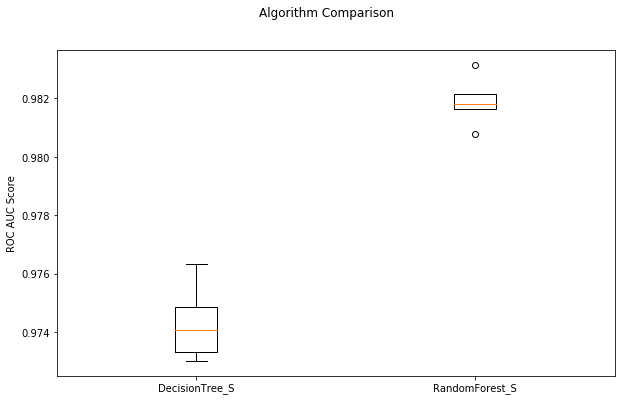

In [33]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_std, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

In [34]:
DT_S.fit(X_train, y_train)
dt_pred_proba = DT_S.predict_proba(X_test)[:, 1]

RF_S.fit(X_train, y_train)
rf_pred_proba = RF_S.predict_proba(X_test)[:, 1]

In [35]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)

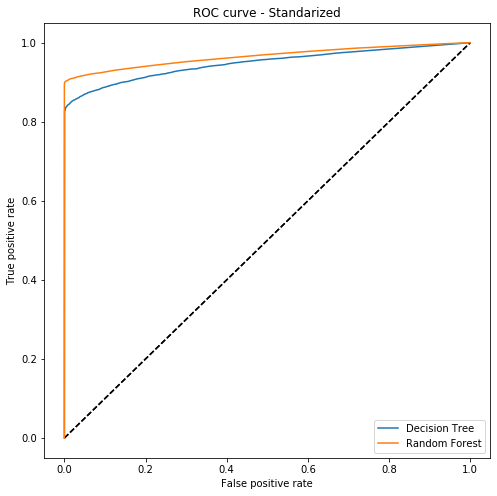

In [36]:
plt.figure(figsize=(8,8))

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Standarized')
plt.legend(loc='lower right')

plt.show()

## Normalized Data

In [37]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_norm, y, test_size=0.3, random_state=0)

### Decision Tree (Base)

In [38]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion = "entropy", random_state=0)
dtree.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [39]:
dtree_pred = dtree.predict(X_test2)
cm = confusion_matrix(y_test2,dtree_pred)
print(cm)

[[8299  955]
 [ 806 8642]]


In [40]:
cr = classification_report(y_test2,dtree_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9254
           1       0.90      0.91      0.91      9448

    accuracy                           0.91     18702
   macro avg       0.91      0.91      0.91     18702
weighted avg       0.91      0.91      0.91     18702



In [41]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test2, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test2, dtree_pred)))

accuracy_dtree = accuracy_score(y_test2, dtree_pred)
precision_dtree = precision_score(y_test2, dtree_pred)
recall_dtree = recall_score(y_test2, dtree_pred)

Accuracy is 0.91
Precision is 0.90
Recall is 0.91


### Random Forest (Base)

In [42]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(criterion = "entropy", random_state=0)
rm.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [43]:
rm_prd = rm.predict(X_test2)
cm = confusion_matrix(y_test2,rm_prd)
print(cm)

[[9231   23]
 [ 897 8551]]


In [44]:
cr = classification_report(y_test2,rm_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       1.00      0.91      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [45]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test2, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test2, rm_prd)))

accuracy_rm = accuracy_score(y_test2, rm_prd)
precision_rm = precision_score(y_test2, rm_prd)
recall_rm = recall_score(y_test2, rm_prd)

Accuracy is 0.95
Precision is 1.00
Recall is 0.91


### Decision Tree (CV)

In [46]:
from sklearn.model_selection import GridSearchCV

DT_N = DecisionTreeClassifier(criterion= "entropy",random_state=0)
dt_params = {'max_depth': np.arange(
    1, 25), 'min_samples_leaf': np.arange(2, 25)}

GS_dt = GridSearchCV(DT_N, dt_params, cv=5, scoring='roc_auc')
GS_dt.fit(X_norm, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 

In [47]:
GS_dt.best_params_

{'max_depth': 23, 'min_samples_leaf': 18}

In [53]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=23, criterion = "entropy", min_samples_split=18)
dtree.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=23, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [54]:
dtree_pred = dtree.predict(X_test2)
cm = confusion_matrix(y_test2,dtree_pred)
print(cm)

[[8525  729]
 [ 894 8554]]


In [55]:
cr = classification_report(y_test2,dtree_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      9254
           1       0.92      0.91      0.91      9448

    accuracy                           0.91     18702
   macro avg       0.91      0.91      0.91     18702
weighted avg       0.91      0.91      0.91     18702



In [56]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test2, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test2, dtree_pred)))

accuracy_dtree = accuracy_score(y_test2, dtree_pred)
precision_dtree = precision_score(y_test2, dtree_pred)
recall_dtree = recall_score(y_test2, dtree_pred)

Accuracy is 0.91
Precision is 0.92
Recall is 0.91


### Random Forest (CV)

In [52]:
import sklearn.model_selection as model_selection

auc_avg = []
auc_var = []
x_axis = np.arange(1, 40)
for ne in x_axis:
    RF_N = RandomForestClassifier(n_estimators=ne, random_state=0)
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    auc = model_selection.cross_val_score(
        RF_N, X_norm, y, cv=5, scoring='roc_auc')
    auc_avg.append(1-np.mean(auc))
    auc_var.append(np.var(auc, ddof=1))

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Bias Error')
plt.plot(x_axis,auc_avg)

plt.subplot(1,2,2)
plt.title('Variance Error')
plt.plot(x_axis,auc_var)
plt.show()

In [ ]:
#Finding Lowest Variance Error
print(np.argmin(auc_var))
print(auc_var[np.argmin(auc_var)])
print(auc_avg[np.argmin(auc_var)])

In [ ]:
#Finding Lowest Bias Error
print(np.argmin(auc_avg))
print(auc_var[np.argmin(auc_avg)])
print(auc_avg[np.argmin(auc_avg)])

In [61]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 38, random_state=0)
rm.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=38,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [62]:
rm_prd = rm.predict(X_test2)
cm = confusion_matrix(y_test2,rm_prd)
print(cm)

[[9225   29]
 [ 895 8553]]


In [63]:
cr = classification_report(y_test2,rm_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       1.00      0.91      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [64]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test2, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test2, rm_prd)))

accuracy_rm = accuracy_score(y_test2, rm_prd)
precision_rm = precision_score(y_test2, rm_prd)
recall_rm = recall_score(y_test2, rm_prd)

Accuracy is 0.95
Precision is 1.00
Recall is 0.91


In [65]:
# Declaring final models with best parameters
DT_N = DecisionTreeClassifier(max_depth=23, min_samples_leaf=18, random_state=0)
RF_N = RandomForestClassifier(n_estimators=38, random_state=0)

In [66]:
models = []
models.append(('DecisionTree_N',DT_N))
models.append(('RandomForest_N',RF_N))

DecisionTree_N: 0.949479 (0.000011)
RandomForest_N: 0.970467 (0.000004)


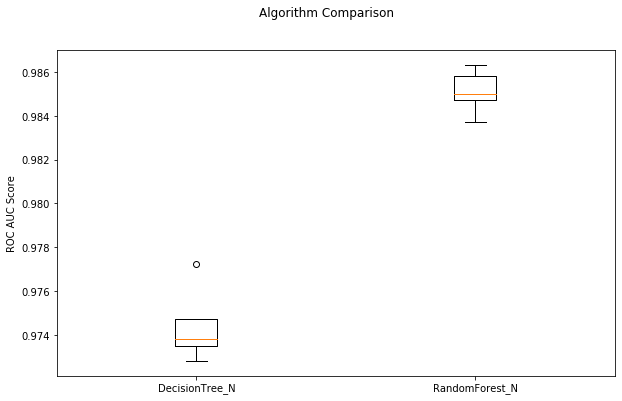

In [67]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_norm, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

In [68]:
DT_N.fit(X_train2, y_train2)
dt_pred_proba2 = DT_N.predict_proba(X_test2)[:, 1]

RF_N.fit(X_train2, y_train2)

rf_pred_proba2 = RF_N.predict_proba(X_test2)[:, 1]

In [69]:
fpr_dt2, tpr_dt2, _ = roc_curve(y_test2, dt_pred_proba2)
fpr_rf2, tpr_rf2, _ = roc_curve(y_test2, rf_pred_proba2)

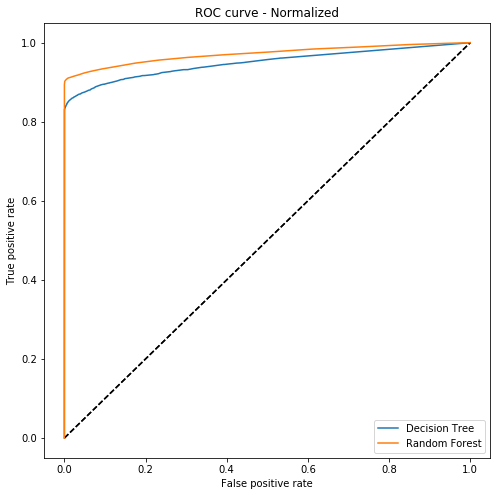

In [70]:
plt.figure(figsize=(8,8))

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt2, tpr_dt2, label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Normalized')
plt.legend(loc='lower right')

plt.show()

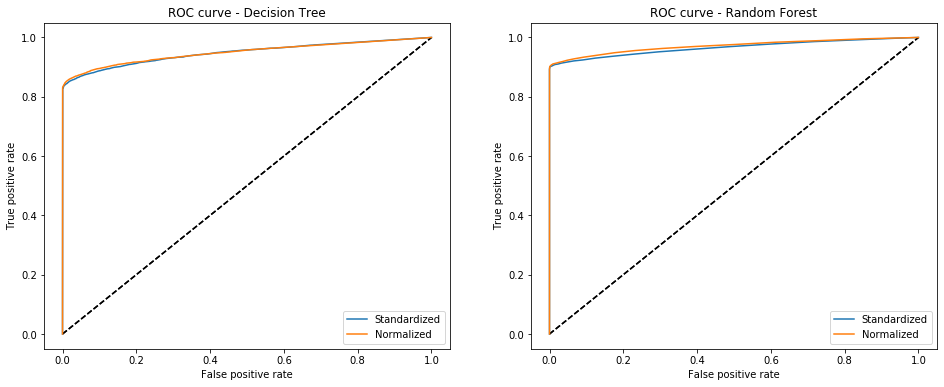

In [71]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='Standardized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt2, tpr_dt2, label='Normalized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Decision Tree')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Standardized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='Normalized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest')
plt.legend(loc='lower right')

plt.show()

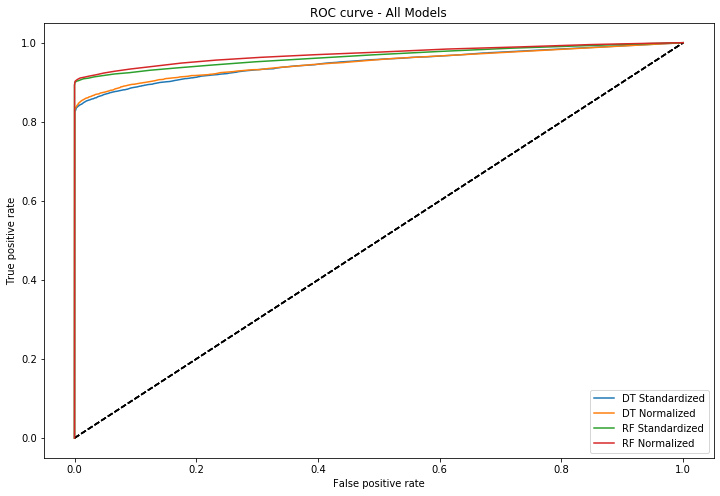

In [72]:
plt.figure(figsize=(12,8))

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT Standardized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt2, tpr_dt2, label='DT Normalized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Decision Tree')
plt.legend(loc='lower right')

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF Standardized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='RF Normalized')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - All Models')
plt.legend(loc='lower right')

plt.show()

### Final Comparison

In [73]:
models = []
models.append(('DecisionTree_S',DT_S))
models.append(('RandomForest_S',RF_S))

models2 = []
models2.append(('DecisionTree_N',DT_N))
models2.append(('RandomForest_N',RF_N))

DecisionTree_S: 0.949316 (0.000007)
RandomForest_S: 0.964145 (0.000003)
DecisionTree_N: 0.949479 (0.000011)
RandomForest_N: 0.970467 (0.000004)


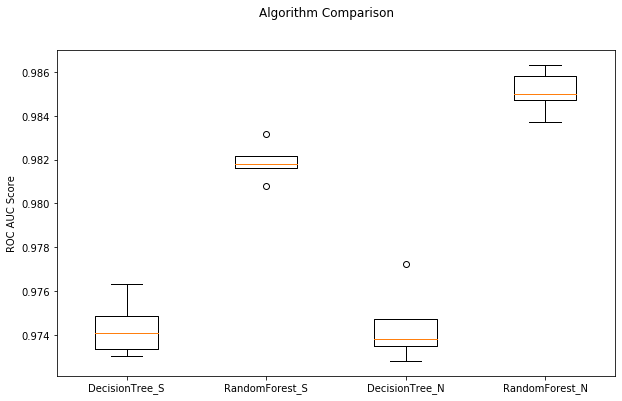

In [74]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_std, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))

for name, model in models2:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_norm, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))

   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

## Boosting

### AdaBoost

In [117]:
ABDT = AdaBoostClassifier(base_estimator=DT_N)
ABDT.fit(X_train2, y_train2)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=23,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=18,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                        

In [78]:
ABDT_prd = ABDT.predict(X_test2)
cm = confusion_matrix(y_test2,ABDT_prd)
print(cm)

[[9072  182]
 [ 872 8576]]


In [79]:
cr = classification_report(y_test2,ABDT_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9254
           1       0.98      0.91      0.94      9448

    accuracy                           0.94     18702
   macro avg       0.95      0.94      0.94     18702
weighted avg       0.95      0.94      0.94     18702



In [80]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, ABDT_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test2, ABDT_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test2, ABDT_prd)))

Accuracy is 0.94
Precision is 0.98
Recall is 0.91


In [82]:
ABRF = AdaBoostClassifier(base_estimator=RF_N)
ABRF.fit(X_train2, y_train2)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                       

In [83]:
ABRF_prd = ABRF.predict(X_test2)
cm = confusion_matrix(y_test2,ABRF_prd)
print(cm)

[[9232   22]
 [ 868 8580]]


In [84]:
cr = classification_report(y_test2,ABRF_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       1.00      0.91      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.96      0.95      0.95     18702
weighted avg       0.96      0.95      0.95     18702



In [85]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, ABRF_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test2, ABRF_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test2, ABRF_prd)))

accuracy_rm = accuracy_score(y_test2, rm_prd)
precision_rm = precision_score(y_test2, rm_prd)
recall_rm = recall_score(y_test2, rm_prd)

Accuracy is 0.95
Precision is 1.00
Recall is 0.91


In [86]:
# Declaring final models with best parameters
ABDT = AdaBoostClassifier(base_estimator=DT_N)
ABDT = AdaBoostClassifier(base_estimator=RF_N)

In [87]:
models = []
models.append(('AdaBoost_DecisionTree',ABDT))
models.append(('AdaBoost_RandomForest',ABRF))

In [89]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_norm, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

KeyboardInterrupt: 

In [91]:
kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
cv_results = model_selection.cross_val_score(
    ABDT, X_norm, y, cv=kfold, scoring='roc_auc')
results.append(np.sqrt(np.abs(cv_results)))
print("%s: %f (%f)" % ("ABDT", np.mean(cv_results),
                       np.var(cv_results, ddof=1)))

KeyboardInterrupt: 

In [ ]:
kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
cv_results = model_selection.cross_val_score(
    ABRF, X_norm, y, cv=kfold, scoring='roc_auc')
results.append(np.sqrt(np.abs(cv_results)))
print("%s: %f (%f)" % ("ABRF", np.mean(cv_results),
                       np.var(cv_results, ddof=1)))

### XG Boost

In [97]:
XB = XGBClassifier(objective='binary:logistic')
XB.fit(X_train, y_train,eval_metric = 'auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
XB_prd = XB.predict(X_test)
cm = confusion_matrix(y_test,XB_prd)
print(cm)

[[9207   47]
 [ 912 8536]]


In [100]:
cr = classification_report(y_test,XB_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9254
           1       0.99      0.90      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [102]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, XB_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, XB_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, XB_prd)))

Accuracy is 0.95
Precision is 0.99
Recall is 0.90


In [104]:
XB = XGBClassifier(objective='binary:logistic')
XB.fit(X_train2, y_train2,eval_metric = 'auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
XB_prd = XB.predict(X_test2)
cm = confusion_matrix(y_test2,XB_prd)
print(cm)

[[9210   44]
 [ 898 8550]]


In [106]:
cr = classification_report(y_test2,XB_prd)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9254
           1       0.99      0.90      0.95      9448

    accuracy                           0.95     18702
   macro avg       0.95      0.95      0.95     18702
weighted avg       0.95      0.95      0.95     18702



In [107]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test2, XB_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test2, XB_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test2, XB_prd)))

Accuracy is 0.95
Precision is 0.99
Recall is 0.90


In [65]:
# Declaring final models with best parameters
DT_N = DecisionTreeClassifier(max_depth=23, min_samples_leaf=18, random_state=0)
RF_N = RandomForestClassifier(n_estimators=38, random_state=0)

## Final model comparison in terms of roc_auc_score

In [145]:
models = []
models.append(('NaiveBayes',gb))
models.append(('DecisionTree_N',DT_N))
models.append(('RandomForest_N',RF_N))
models.append(('XGBoost', XB))
models.append(('AdaBoost_DT',ABDT))
models.append(('AdaBoost_RF',ABRF))

NaiveBayes: 0.550648 (0.000015)
DecisionTree_N: 0.949479 (0.000011)
RandomForest_N: 0.970467 (0.000004)
XGBoost: 0.962046 (0.000008)
AdaBoost_DT: 0.965285 (0.000005)
AdaBoost_RF: 0.974585 (0.000003)


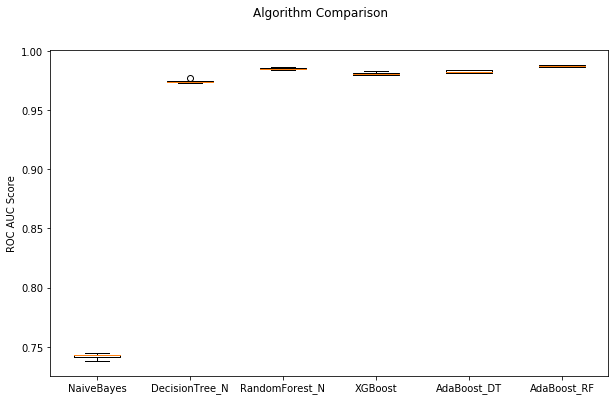

In [146]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(
        model, X_norm, y, cv=kfold, scoring='roc_auc')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),
                           np.var(cv_results, ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

In [168]:
## Gaussian NB
# from sklearn.metrics import roc_auc_score
# from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()
gb.fit(X_train2, y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [166]:
expected = y_test2
predicted = gb.predict(X_test2)

print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

              precision    recall  f1-score   support

           0       0.83      0.11      0.19      9254
           1       0.53      0.98      0.69      9448

    accuracy                           0.55     18702
   macro avg       0.68      0.54      0.44     18702
weighted avg       0.68      0.55      0.44     18702

[[1023 8231]
 [ 216 9232]]
0.5438424046026644


In [167]:

print("Accuracy is {0:.2f}".format(accuracy_score(expected, predicted)))
print("Precision is {0:.2f}".format(precision_score(expected, predicted)))
print("Recall is {0:.2f}".format(recall_score(expected, predicted)))

Accuracy is 0.55
Precision is 0.53
Recall is 0.98


## Final Model Comparison in terms of training and testing data

In [121]:
tra_nb = accuracy_score(y_train2, gb.predict(X_train2))
print(ta_nb)
tra_dt = accuracy_score(y_train2, DT_N.predict(X_train2))
print(ta_dt)
tra_rf = accuracy_score(y_train2, RF_N.predict(X_train2))
print(ta_rf)
tra_abdt = accuracy_score(y_train2, ABDT.predict(X_train2))
print(ta_abdt)
tra_abrf = accuracy_score(y_train2, ABRF.predict(X_train2))
print(ta_abrf)
tra_xb = accuracy_score(y_train2, XB.predict(X_train2))
print(ta_xb)

0.5483370762485296
0.9122019035397284
0.9505935194096888
0.9412897016361886
0.9524115067907176
0.9496310555020854


In [122]:
tea_nb = accuracy_score(y_test2, gb.predict(X_test2))
print(ta_nb)
tea_dt = accuracy_score(y_test2, DT_N.predict(X_test2))
print(ta_dt)
tea_rf = accuracy_score(y_test2, RF_N.predict(X_test2))
print(ta_rf)
tea_abdt = accuracy_score(y_test2, ABDT.predict(X_test2))
print(ta_abdt)
tea_abrf = accuracy_score(y_test2, ABRF.predict(X_test2))
print(ta_abrf)
tea_xb = accuracy_score(y_test2, XB.predict(X_test2))
print(ta_xb)

0.5483370762485296
0.9122019035397284
0.9505935194096888
0.9412897016361886
0.9524115067907176
0.9496310555020854


In [155]:
md_df = pd.DataFrame({'Models': ['NB', 'DT', 'RF', 'ABDT', 'ABRF', 'XB'],
                      'Training Accuracy': [tra_nb, tra_dt, tra_rf, tra_abdt, tra_abrf, tra_xb],
                      'Testing Accuracy': [tea_nb, tea_dt, tea_rf, tea_abdt, tea_abrf, tea_xb],
                      '% change': [((tea_nb-tra_nb)*100/tra_nb),((tea_dt-tra_dt)*100/tra_dt),((tea_rf-tra_rf)*100/tra_rf),
                                  ((tea_abdt-tra_abdt)*100/tra_abdt),((tea_abrf-tra_abrf)*100/tra_abrf),((tea_xb-tra_xb)*100/tra_xb)]})
md_df

,Models,Training Accuracy,Testing Accuracy,% change
0,NB,0.542394,0.548337,1.095667
1,DT,0.930496,0.912202,-1.966096
2,RF,0.999496,0.950594,-4.892700
3,ABDT,1.000000,0.941290,-5.871030
4,ABRF,1.000000,0.952412,-4.758849
5,XB,0.961593,0.949631,-1.243983


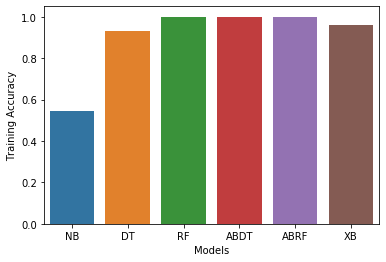

In [136]:
sns.barplot(y="Training Accuracy", x="Models", data=md_df)
plt.show()

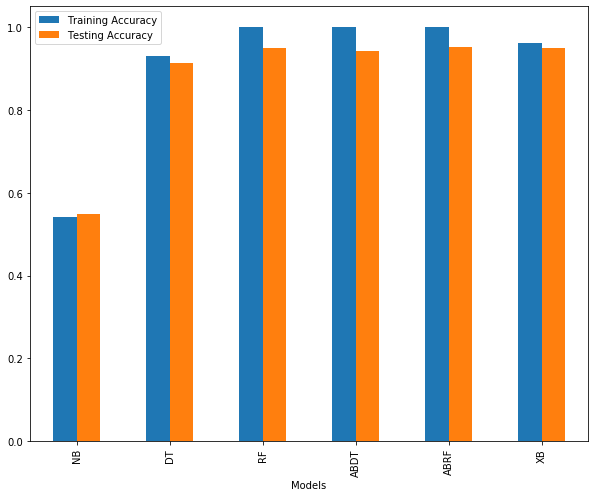

In [157]:
md_df.plot(x='Models',y=['Training Accuracy', 'Testing Accuracy'],kind='bar',figsize=(10,8))
plt.show()

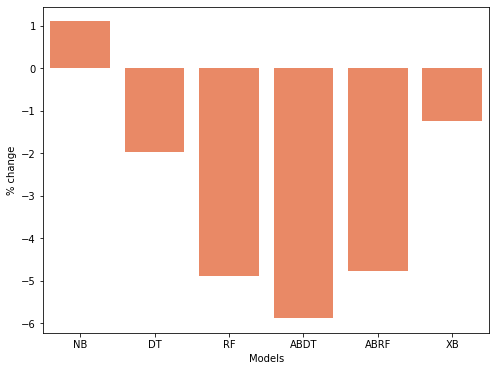

In [164]:
plt.figure(figsize=(8,6))
sns.barplot('Models','% change',data=md_df,color='coral')
#plt.bar('Models','% change',data=md_df)
#plt.x
plt.show()

In [149]:
results_new = results[1:]
results_new

[array([0.97723262, 0.97280513, 0.9734861 , 0.97471909, 0.97381096]),
 array([0.98581816, 0.98372184, 0.98471577, 0.9863439 , 0.98501216]),
 array([0.98291272, 0.97923508, 0.98042582, 0.98164147, 0.97997797]),
 array([0.98382623, 0.98162379, 0.9812713 , 0.98361627, 0.98210602]),
 array([0.9884133 , 0.98643115, 0.98685964, 0.9878784 , 0.98646824])]

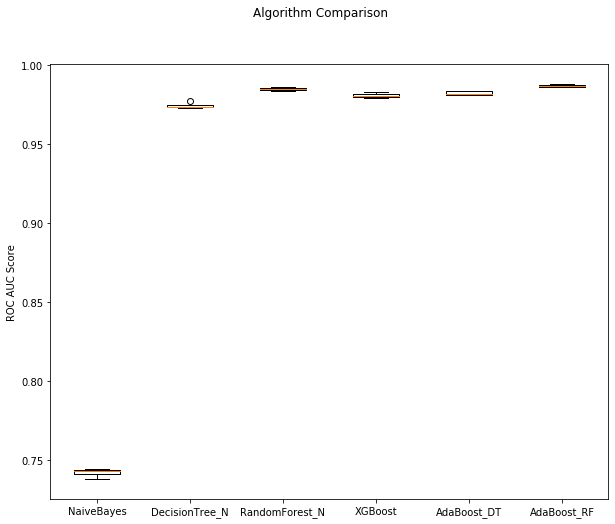

In [152]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score')
plt.show()

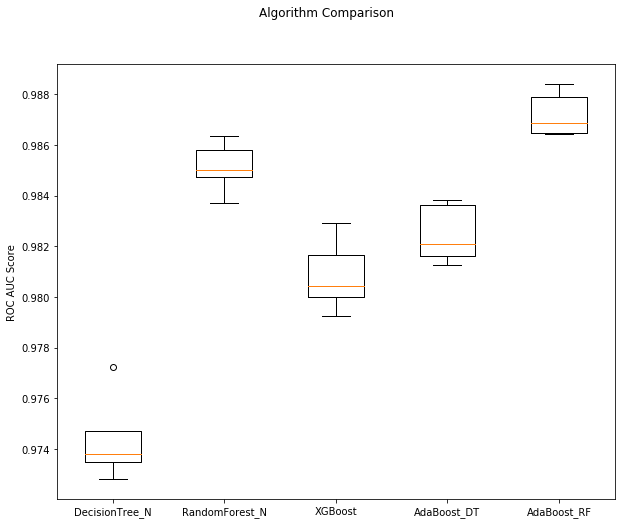

In [153]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results[1:])
ax.set_xticklabels(names[1:])
plt.ylabel('ROC AUC Score')
plt.show()

In [175]:
exec_time = [0.124,1.36,4.81,16.0,106,933.0]

In [169]:
GBN = GaussianNB()
GBN.fit(X_train2,y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [170]:
DTN = DecisionTreeClassifier(max_depth=23, criterion = "entropy", min_samples_split=18)
DTN.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=23, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [171]:
RFN = RandomForestClassifier(n_estimators = 38, criterion='gini',random_state=0)
RFN.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=38,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [172]:
XB = XGBClassifier(objective='binary:logistic')
XB.fit(X_train2, y_train2,eval_metric = 'auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [173]:
ABDT = AdaBoostClassifier(base_estimator=DT_N)
ABDT.fit(X_train2, y_train2)

KeyboardInterrupt: 

## Execution Time Comparison between models

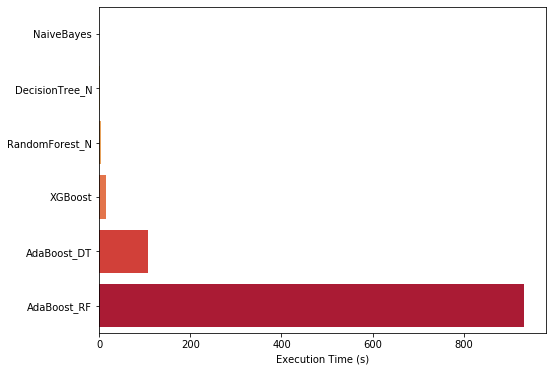

In [183]:
plt.figure(figsize=(8,6))
sns.barplot(x=exec_time,y=names,palette='YlOrRd')
plt.xlabel('Execution Time (s)')
plt.show()